In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn import Module, Conv2d, MaxPool2d, Linear, Sigmoid
import torch.nn.functional as F
from torch.optim import SGD, Adam
import torchvision

# Prepare the data

In [2]:
dataset = torchvision.datasets.Omniglot(
    root="./data", download=True, transform=torchvision.transforms.ToTensor()
)

Files already downloaded and verified


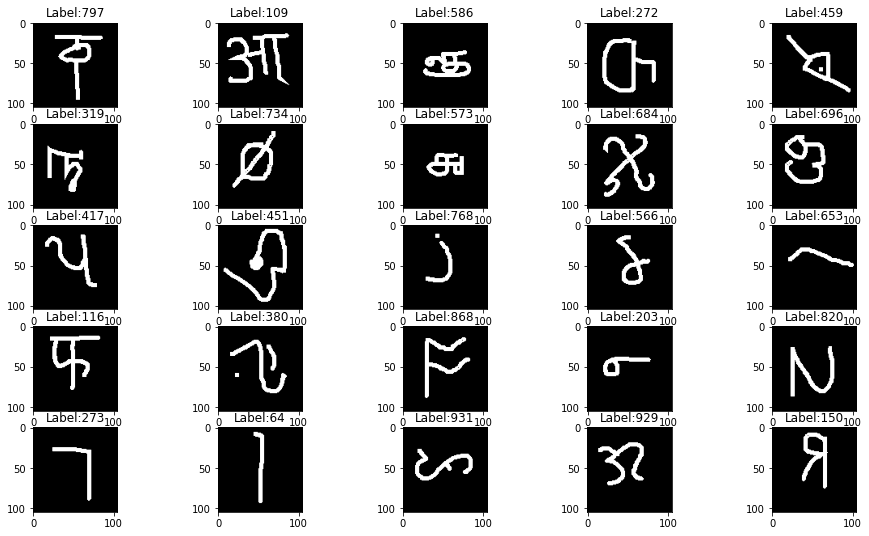

In [3]:
fig, axs = plt.subplots(5, 5, figsize=(16, 9))
for i in range(5):
   for j in range(5):
     k = np.random.randint(0, len(dataset), 1)[0]
     im, lab = dataset[k]
     axs[i,j].imshow(im[0], cmap='Greys')
     axs[i,j].set_title('Label:' + str(lab))
plt.show()

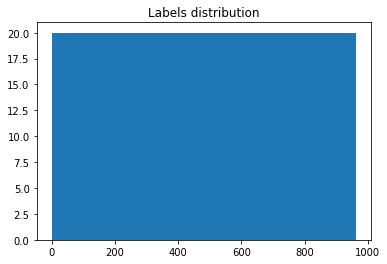

In [4]:
labels = [dataset[i][1] for i in range(len(dataset))]
plt.title('Labels distribution')
plt.hist(labels, bins=len(set(labels)))
plt.show()

In [5]:
print('Number of images:', len(dataset))
print('Number of unique labels:', len(set(labels)))
print('Number of images per label:', len(dataset) // len(set(labels)))

Number of images: 19280
Number of unique labels: 964
Number of images per label: 20


In [6]:
class OmniglotDataset(Dataset):
    def __init__(self, dataset):
        self.images = [dataset[i][0] for i in range(len(dataset))]
        self.labels = np.array([dataset[i][1] for i in range(len(dataset))])
        self.labels_set = set(self.labels)
        self.dict_labels = {label:np.where(self.labels == label)[0] for label in self.labels_set}
        
        positive_pairs = [
            [i, np.random.choice(self.dict_labels[self.labels[i]]), 1] 
                                    for i in range(0, len(dataset), 2)
            ]
        negative_pairs = [
            [i, 
             np.random.choice(self.dict_labels[ np.random.choice( list( self.labels_set - set([self.labels[i]]) ) ) ]),
             0] 
                                    for i in range(1, len(dataset), 2)
            ]
        self.all_pairs = positive_pairs + negative_pairs

    def __len__(self):
        return len(self.all_pairs)

    def __getitem__(self, idx):
        i, j, target = self.all_pairs[idx]
        x1, x2 = self.images[i], self.images[j]
        return (x1, x2), target

In [10]:
train, test = train_test_split(dataset, test_size=.20)
train, valid = train_test_split(train, test_size=.25)

train_dataset = OmniglotDataset(train)
valid_dataset = OmniglotDataset(valid)
test_dataset = OmniglotDataset(test)

train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False)

#test_split, valid_split = .2, .2
#test_size = int(test_split * len(data))
#valid_size = int(valid_split * len(data))
#train_size = len(data) - test_size - valid_size

#assert len(data) == (train_size + valid_size + test_size)

#train, valid, test = random_split(data, [train_size, valid_size, test_size])

#train_dl = DataLoader(data, batch_size=32, shuffle=True)
#valid_dl = DataLoader(data, batch_size=32, shuffle=False)
#test_dl = DataLoader(data, batch_size=32, shuffle=False)

# Define the model

In [45]:
class FeatureExtractor(Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv1_1 = Conv2d(1, 8, 3)
        self.conv1_2 = Conv2d(8, 8, 3)
        self.pool1 = MaxPool2d(2, 2)

        self.conv2_1 = Conv2d(8, 16, 3)
        self.conv2_2 = Conv2d(16, 16, 3)
        self.pool2 = MaxPool2d(2, 2)

        self.conv3_1 = Conv2d(16, 32, 3)
        self.conv3_2 = Conv2d(32, 32, 3)
        self.pool3 = MaxPool2d(2, 2)

        self.fc1 = Linear(32 * 9 * 9, 32)
        self.fc2 = Linear(32, 32)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool1(x)

        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = self.pool3(x)

        x = x.view(x.size()[0], -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

class SiameseNet(Module):
    def __init__(self, emb):
        super(SiameseNet, self).__init__()
        self.emb = emb

    def forward(self, x):
        x1, x2 = x
        features1, features2 = self.emb(x1), self.emb(x2)
        return (features1, features2)

# Define the loss

In [46]:
class ContrastiveLoss(Module):
    def __init__(self, margin=.6):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output, target):
        feature1, feature2 = output
        distances = (feature2 - feature1).pow(2).sum(1)
        pos_loss = target.float() * distances
        neg_loss = (1 - target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2)
        loss = .5 * (pos_loss + neg_loss)
        return loss.mean()

# Train the model

In [47]:
def evaluate(valid_dl, model, criterion):

    with torch.no_grad():
        total_loss = 0.
        dist_pos, dist_neg = 0., 0.
        total_pos, total_neg = 0, 0
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(valid_dl):
            # put data on gpu
            inputs = tuple(x.cuda() for x in inputs)
            targets = targets.cuda()
            # compute the model output
            outputs = model(inputs)
            # calculate loss
            loss = criterion(outputs, targets)
            #loss.cuda()
            total_loss += loss

            feature1, feature2 = outputs
            distances = (feature2 - feature1).pow(2).sum(1)
            dist_pos += (targets * distances).sum()
            dist_neg += ((1 - targets) * distances).sum()
            total_pos += targets.sum()
            total_neg += len(targets) - targets.sum()
        
        total_loss = total_loss / len(valid_dl)
        dist_pos = dist_pos / total_pos
        dist_neg = dist_neg / total_neg

        total_loss = float(total_loss.cpu().detach().numpy())
        dist_pos = float(dist_pos.cpu().detach().numpy())
        dist_neg = float(dist_neg.cpu().detach().numpy())

        return total_loss, dist_pos, dist_neg

In [48]:
lr = 1e-4
num_epochs = 20

In [49]:
feature_extractor = FeatureExtractor()
model = SiameseNet(feature_extractor)
model.cuda()

SiameseNet(
  (emb): FeatureExtractor(
    (conv1_1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (conv1_2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv2_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv3_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=2592, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=32, bias=True)
  )
)

In [50]:
criterion = ContrastiveLoss()
optimizer = Adam(model.parameters(), lr=lr)

In [51]:
train_loss = []
valid_loss = []
pos_loss = []
neg_loss = []

_, dist_pos, dist_neg = evaluate(valid_dl, model, criterion)
pos_loss.append(dist_pos)
neg_loss.append(dist_neg)

# enumerate epochs
for epoch in range(num_epochs):
    total_loss = 0.
    
    # enumerate mini batches
    for i, (inputs, targets) in enumerate(train_dl):
        # put data on gpu
        inputs = tuple(x.cuda() for x in inputs)
        targets = targets.cuda()

        # clear the gradients
        optimizer.zero_grad()

        # compute the model output
        outputs = model(inputs)

        # calculate loss
        loss = criterion(outputs, targets)
        loss.cuda()

        # credit assignment
        loss.backward()

        # update model weights
        optimizer.step()

        total_loss += loss
    
    l = total_loss / len(train_dl)
    l = float(l.cpu().detach().numpy())    
    train_loss.append(l)

    valid_l, dist_pos, dist_neg = evaluate(valid_dl, model, criterion)
    valid_loss.append(valid_l)
    pos_loss.append(dist_pos)
    neg_loss.append(dist_neg)

    if epoch % 5 == 0:
        print('Epoch:'+str(epoch)+'; Loss (train):'+str(l)+'; Loss (valid):'+str(valid_l))

Epoch:0; Loss (train):0.036187607795000076; Loss (valid):0.02446048893034458
Epoch:5; Loss (train):0.021895399317145348; Loss (valid):0.020109649747610092
Epoch:10; Loss (train):0.017648320645093918; Loss (valid):0.017055712640285492
Epoch:15; Loss (train):0.015681806951761246; Loss (valid):0.016090458258986473


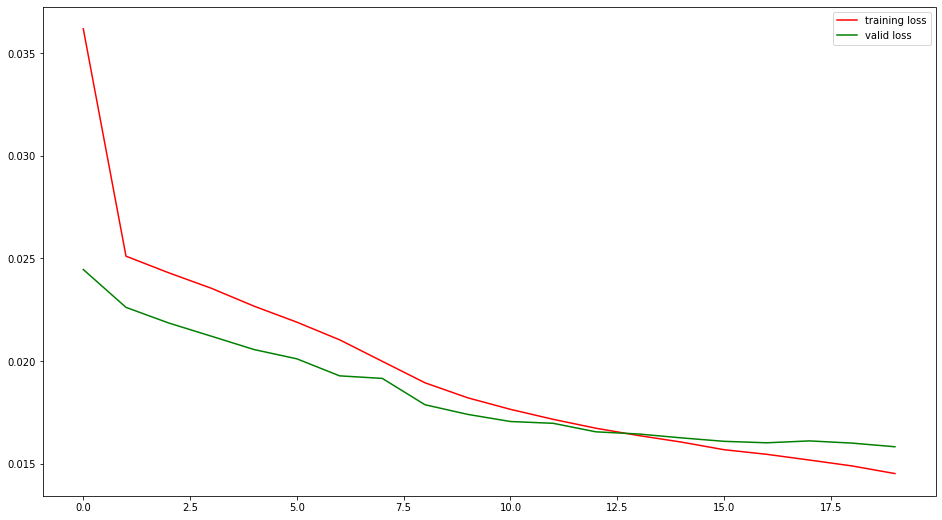

In [52]:
plt.figure(figsize=(16, 9))
plt.plot(train_loss, label='training loss', c='r')
plt.plot(valid_loss, label='valid loss', c='g')
plt.legend()
plt.show()

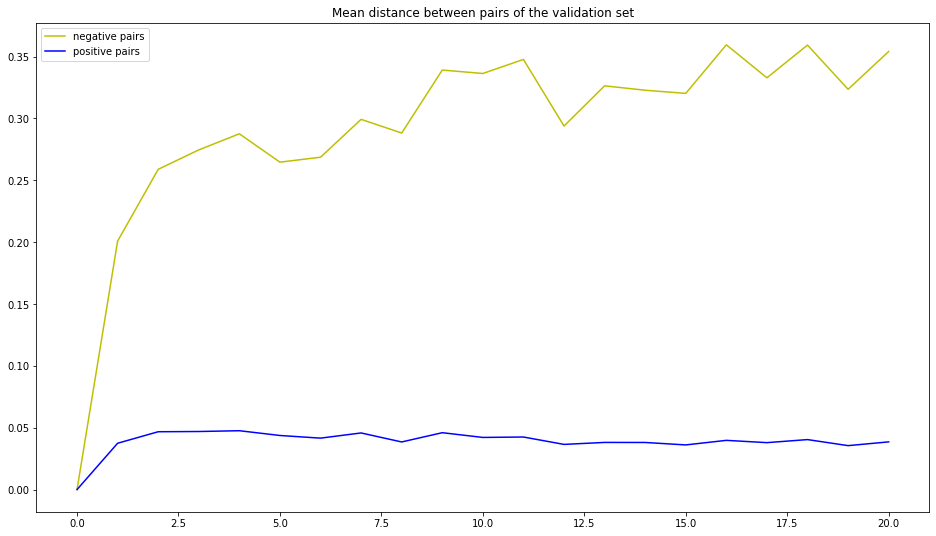

In [53]:
plt.figure(figsize=(16, 9))
plt.title('Mean distance between pairs of the validation set')
plt.plot(neg_loss, label='negative pairs', c='y')
plt.plot(pos_loss, label='positive pairs', c='b')
plt.legend()
plt.show()

# Evaluate the model & Visualization

In [54]:
l, dist_pos, dist_neg = evaluate(valid_dl, model, criterion)
print(l, dist_pos, dist_neg)

0.015825800597667694 0.03854374215006828 0.3541105091571808


In [65]:
features = []
labels = []

for im, l in valid:
    im = im.view((1, 1, 105, 105))
    im = im.cuda()
    f = feature_extractor(im)
    f = f.cpu().detach().numpy()[0]
    features.append(f)
    labels.append(l)

features, labels = np.array(features), np.array(labels)

In [66]:
subsample = np.random.choice(len(labels), 1000)
sub_f, sub_l = features[subsample], labels[subsample]

In [67]:
X_embedded = TSNE(n_components=2).fit_transform(sub_f)

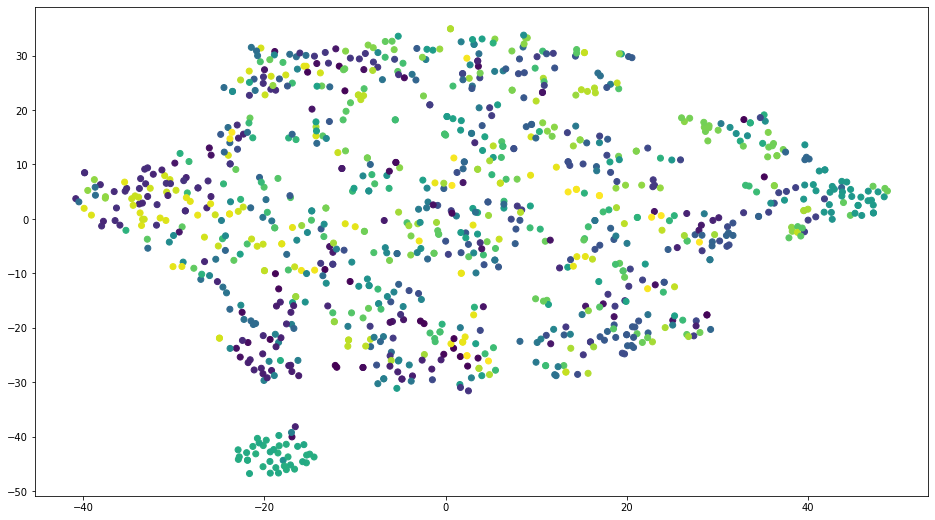

In [68]:
plt.figure(figsize=(16, 9))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=sub_l)
plt.show()

In [69]:
def R_precision(features, labels):
    neighbors = KNeighborsClassifier(n_neighbors=20)
    neighbors.fit(features, labels)

    dict_labels = {l:np.sum(labels == l) for l in set(labels)}

    R_precision = 0.
    for f, l in zip(features, labels):
        R = dict_labels[l]
        neigh_dist, neigh_ind = neighbors.kneighbors(f.reshape((1, -1)))
        neigh_dist, neigh_ind = neigh_dist[:,:R], neigh_ind[:,:R]
        neigh_labels = labels[neigh_ind]
        r = np.sum(neigh_labels == l)
        R_precision += r / R
    R_precision /= len(labels)
    return R_precision

In [70]:
R_precision(features, labels)

0.3585238218731496